In [558]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
import logging
from scipy import fft,signal

In [206]:
lip_filepath = "/home/INT/losada.c/Documents/data/test/lip/2022-12-16_10-30-59_Riesling_lip_e1_r1.npy"
v4_filepath = "/home/INT/losada.c/Documents/data/test/v4/2022-12-16_10-30-59_Riesling_v4_e1_r1.npy"
pfc_filepath = "/home/INT/losada.c/Documents/data/test/pfc/2022-12-16_10-30-59_Riesling_pfc_e1_r1.npy"
#2022-12-14_10-50-49_Riesling_lip_e1_r1  2022-11-22_10-59-03_Riesling_lip_e1_r1

In [628]:
lip_filepath2 = "/home/INT/losada.c/Documents/data/test/lip/2022-12-14_10-50-49_Riesling_lip_e1_r1.npy"
v4_filepath2 = "/home/INT/losada.c/Documents/data/test/v4/2022-12-14_10-50-49_Riesling_v4_e1_r1.npy"
pfc_filepath2 = "/home/INT/losada.c/Documents/data/test/pfc/2022-12-14_10-50-49_Riesling_pfc_e1_r1.npy"

In [207]:
def load_file(filepath):
    py_f = np.load(filepath,allow_pickle=True).item(0)
    sp = py_f['sp_data']
    bhv = py_f['bhv']
    return sp,bhv

In [208]:
lip_sp,lip_bhv = load_file(lip_filepath)
v4_sp,v4_bhv = load_file(v4_filepath)
pfc_sp,pfc_bhv = load_file(pfc_filepath)

In [629]:
lip_sp2,lip_bhv2 = load_file(lip_filepath2)
v4_sp2,v4_bhv2 = load_file(v4_filepath2)
pfc_sp2,pfc_bhv2 = load_file(pfc_filepath2)

In [633]:
trial_idx = select_trials.select_trials_block(lip_sp, n_block=1)
trial_idx = select_trials.select_correct_trials(lip_bhv, trial_idx)
b_sp_samples = [lip_sp["sp_samples"][i] for i in trial_idx]
logging.info("Number of clusters: %d" % len(b_sp_samples[0]))
task = def_task.create_task_frame(trial_idx, lip_bhv, task_constants.SAMPLES_COND)
#fig_task, data_task = def_task.info_task(task)

Number of trials in block 1: 1340
Number of correct trials in block 2: 582


In [634]:
trial_idx2 = select_trials.select_trials_block(lip_sp2, n_block=1)
trial_idx2 = select_trials.select_correct_trials(lip_bhv2, trial_idx2)
b_sp_samples2 = [lip_sp2["sp_samples"][i] for i in trial_idx2]
logging.info("Number of clusters: %d" % len(b_sp_samples[0]))
task2 = def_task.create_task_frame(trial_idx2, lip_bhv2, task_constants.SAMPLES_COND)
#fig_task, data_task = def_task.info_task(task)

Number of trials in block 1: 1753
Number of correct trials in block 2: 874


In [445]:
cgroup = "good"
in_out=1
e_align=2
neurons = np.where(lip_sp["clustersgroup"] == cgroup)[0]
lip_fr_samples, lip_max_shift = firing_rate.fr_by_sample_neuron(
        sp=lip_sp,
        neurons=neurons,
        task=task,
        in_out=in_out,
        kernel=0,
        e_align=e_align,
        plot=False
    )
neurons = np.where(v4_sp["clustersgroup"] == cgroup)[0]
v4_fr_samples, v4_max_shift = firing_rate.fr_by_sample_neuron(
        sp=v4_sp,
        neurons=neurons,
        task=task,
        in_out=in_out,
        kernel=0,
        e_align=e_align,
        plot=False
    )
neurons = np.where(pfc_sp["clustersgroup"] == cgroup)[0]
pfc_fr_samples, pfc_max_shift = firing_rate.fr_by_sample_neuron(
        sp=pfc_sp,
        neurons=neurons,
        task=task,
        in_out=in_out,
        kernel=0,
        e_align=e_align,
        plot=False
    )

In [635]:
cgroup = "good"
in_out=1
e_align=2
neurons2 = np.where(lip_sp2["clustersgroup"] == cgroup)[0]
lip_fr_samples2, lip_max_shift2 = firing_rate.fr_by_sample_neuron(
        sp=lip_sp2,
        neurons=neurons2,
        task=task2,
        in_out=in_out,
        kernel=0,
        e_align=e_align,
        plot=False
    )

In [668]:
def compute_dilation(neuron_fr,lip_sp):
    x_position,y_position, eyes_dilation = [],[],[]
    trials = neuron_fr['trial_idx'].values
    ev_ts = firing_rate.select_events_timestamps(
                lip_sp, trials, task_constants.EVENTS_B1
            ) 
    shift_ev_ts = np.floor(((ev_ts.T - ev_ts.T[0]).T) / config.DOWNSAMPLE)
    for i_t,i_trial in enumerate(trials):
        start = shift_ev_ts[i_t,2]+458-250

        end = start+458#shift_ev_ts[i_t,3]

        dilation = lip_sp['eyes_values'][i_trial][2,start:end].tolist()#[:min_dif]
        x_pos = lip_sp['eyes_values'][i_trial][0,start:end].tolist()
        y_pos = lip_sp['eyes_values'][i_trial][1,start:end].tolist()
        #mean_rolling=mean_rolling[range(0,len(mean_rolling),eyes_step)]
        eyes_dilation.append(dilation)
        x_position.append(x_pos)
        y_position.append(y_pos)
    eyes_dilation = np.array(eyes_dilation)
    x_position = np.array(x_position)
    y_position = np.array(y_position)
    return x_position,y_position,eyes_dilation

In [669]:
dilation_max=0
dilation_min=0
for i_t,i_trial in enumerate(lip_fr_samples['trial_idx'].values):

    d_max = max(lip_sp['eyes_values'][i_trial][2])
    d_min = min(lip_sp['eyes_values'][i_trial][2])
    dilation_max = d_max if d_max>dilation_max else dilation_max
    dilation_min = d_min if d_min<dilation_min else dilation_min

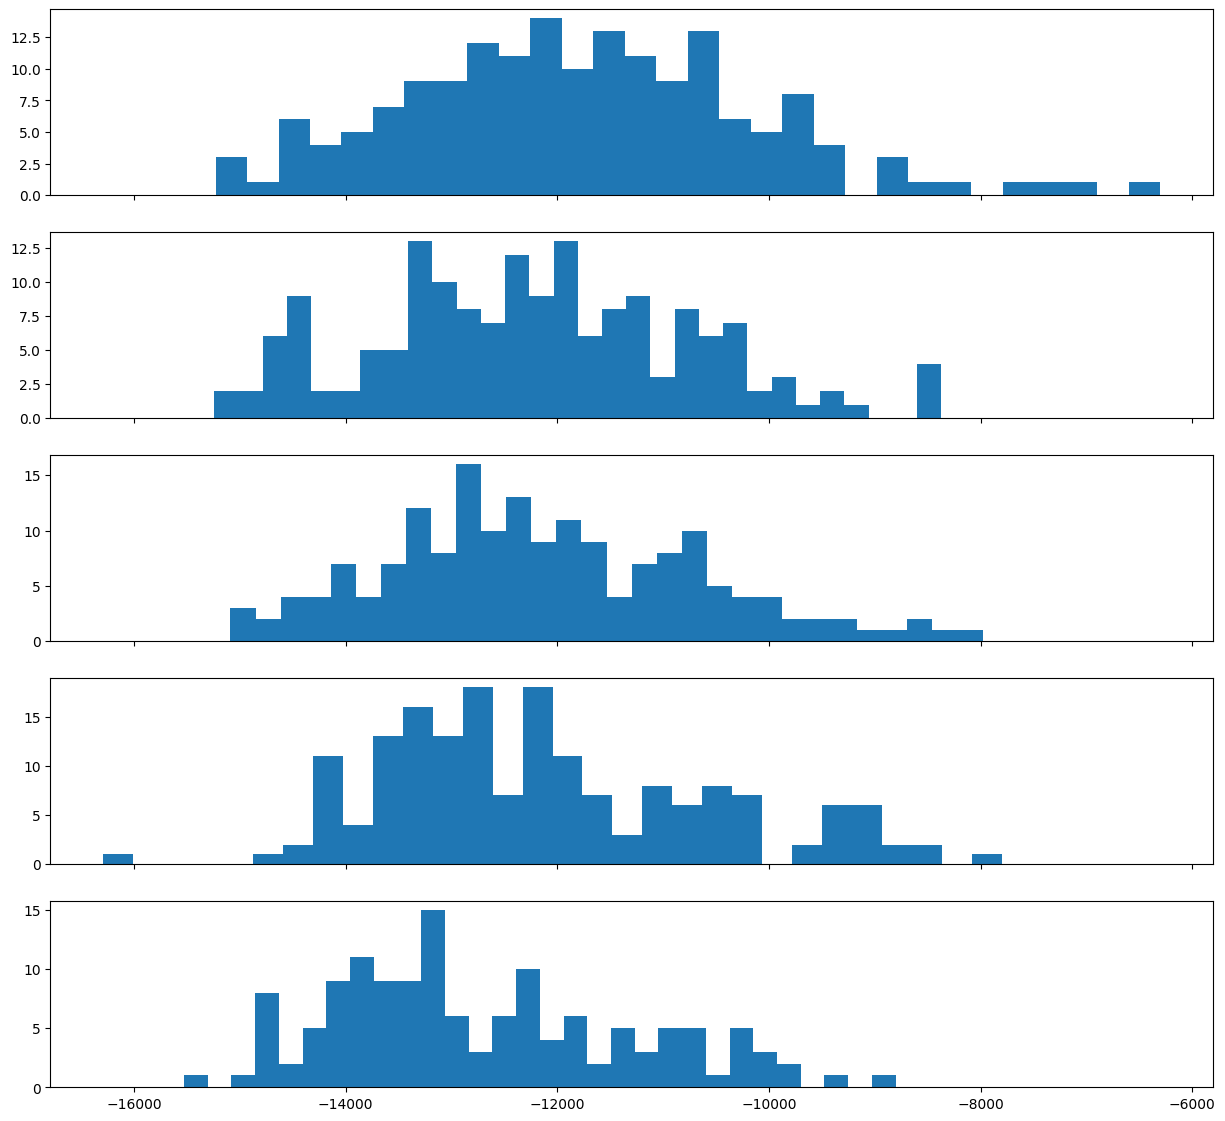

In [670]:
fig,ax = plt.subplots(5,1,figsize=(15,14),sharex=True)
# fig2,ax2 = plt.subplots(5,1,figsize=(15,14))
# fig3,ax3 = plt.subplots(5,1,figsize=(15,14))
all=[]
for i,sample in enumerate(list(task_constants.PALETTE_B1.keys())):
    neuron_fr = lip_fr_samples[(lip_fr_samples['neuron']== 8) & (lip_fr_samples['sample']==sample)]
    x_position,y_position,eyes_dilation = compute_dilation(neuron_fr,lip_sp)
    mean_dilation = eyes_dilation.mean(axis=1)
    
    neuron_fr2 = lip_fr_samples2[(lip_fr_samples2['neuron']== 8) & (lip_fr_samples2['sample']==sample)]
    x_position2,y_position2,eyes_dilation2 = compute_dilation(neuron_fr2,lip_sp2)
    mean_dilation2 = eyes_dilation2.mean(axis=1)
    days = np.concatenate((mean_dilation,mean_dilation2))
    ax[i].hist(days,bins=30)
    all.append(days)
    #std_dilation = eyes_dilation.std(axis=0)
    #ax[i].plot(eyes_dilation.T,color='grey')
    #sns.heatmap(eyes_dilation,cmap='viridis',ax=ax[i],vmin=-16000,vmax=1000)
    #ax[i].plot((eyes_dilation.T ))
    #ax[i].fill_between(x=range(eyes_dilation.shape[1]),y1=mean_dilation-std_dilation,y2=mean_dilation+std_dilation,alpha=0.6,color=task_constants.PALETTE_B1[sample])
    #ax[i].plot(mean_dilation,color='k')
    #sns.heatmap(x_position,cmap='viridis',ax=ax2[i],vmax=-11100,vmin=-12700)
    #sns.heatmap(x_position,cmap='viridis',ax=ax3[i])
    # ax2[i].plot(x_position.T,color='b')
    # ax3[i].plot(y_position.T,color='r')
   

In [671]:
print(len(all[0]))
print(len(all[3]))

169
173


In [673]:
print(stats.ttest_ind(all[-1], all[0]))
print(stats.ttest_ind(all[-1], all[1]))
print(stats.ttest_ind(all[-1], all[2]))
print(stats.ttest_ind(all[-1], all[3]))



Ttest_indResult(statistic=-5.239149247417059, pvalue=3.0147324944252304e-07)
Ttest_indResult(statistic=-2.84616773747776, pvalue=0.0047287924963653844)
Ttest_indResult(statistic=-3.4356166569923428, pvalue=0.0006720728929937588)
Ttest_indResult(statistic=-3.503243670281211, pvalue=0.0005274955278773194)


: 

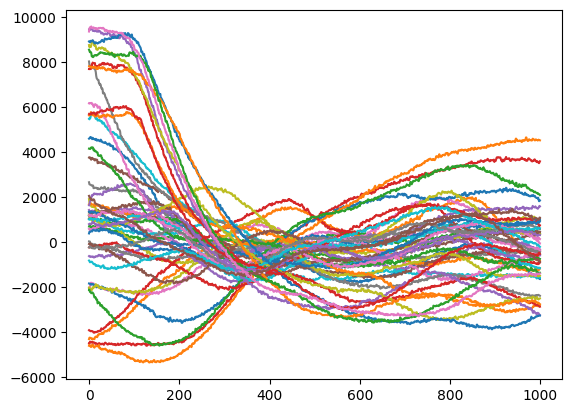

In [566]:
plt.plot(np.arange(0,len(eyes_dilation.T)),eyes_dilation.T - eyes_dilation.T.mean(axis=0))
plt.show()

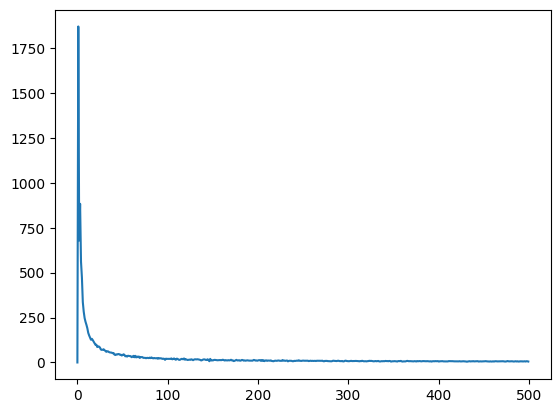

In [567]:
i_e=0
sig = eyes_dilation[i_e]-np.mean(eyes_dilation[i_e])
T= 1/1000
N=len(sig)
x=np.linspace(0,N*T,N)
yf = fft.fft(sig)
xf = fft.fftfreq(N,T)[:N//2]
plt.plot(xf,2.0/N * np.abs(yf[0:N//2]))

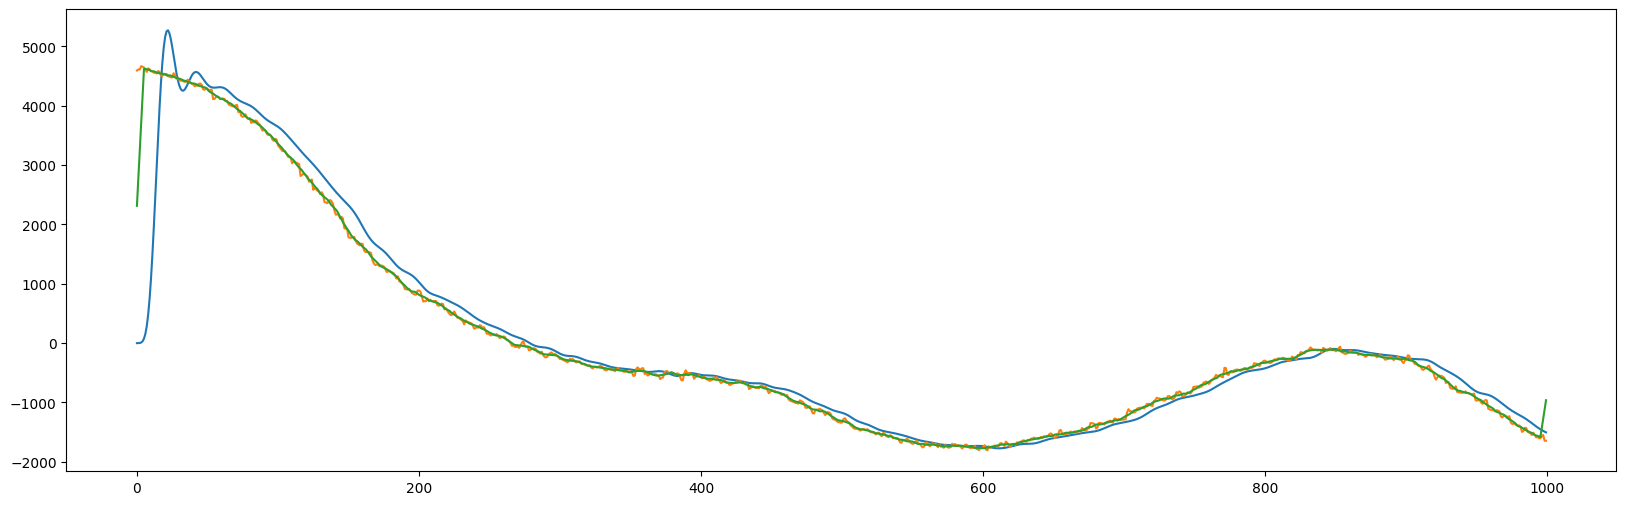

In [577]:
fs=1000
fc_lp=50
sos = signal.butter(6, fc_lp, "lp", fs=fs, output="sos")
f_sig = signal.sosfilt(sos, sig)
fig,ax = plt.subplots(figsize=(20,6))
plt.plot(np.arange(0,len(f_sig)),f_sig)
plt.plot(np.arange(0,len(sig)),sig)

plt.plot(np.arange(0,len(sig)),np.convolve(sig,np.ones(10),'same')/10)
plt.show()

### Correlation coef

In [584]:
def compute_corr_coef(neuron_fr,t_before,t_after,win_size,step,fr_shift=0,eyes_shift=0):
    eyes_dilation = []
    fr = []
    trials = neuron_fr['trial_idx'].values
    ev_ts = firing_rate.select_events_timestamps(
                lip_sp, trials, task_constants.EVENTS_B1
            ) 
    shift_ev_ts = np.floor(((ev_ts.T - ev_ts.T[0]).T) / config.DOWNSAMPLE)
    fr_start = neuron_fr['sample_on'].values-t_before
    fr_end = neuron_fr['sample_off'].values+t_after
    min_dif = min(fr_end-fr_start)
    mean_fr_window = neuron_fr.iloc[:,:-6].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()
    for i_t,i_trial in enumerate(trials):
        fr.append(mean_fr_window.iloc[i_t,fr_start[i_t]:fr_end[i_t]].values[:min_dif]) 
        start = shift_ev_ts[i_t,2]-t_before
        end = shift_ev_ts[i_t,3]+t_after
        dil = lip_sp['eyes_values'][i_trial][2,start:end].tolist()[:min_dif]
        eyes_dilation.append(dil)
    eyes_dilation = np.array(eyes_dilation)
    fr = np.array(fr)
    corr_coeff=[]
    max_shift = min([fr.shape[1]-fr_shift,eyes_dilation.shape[1]-eyes_shift])
    for w in range(max_shift):
        if np.all(fr[:,w+fr_shift]==fr[0,w+fr_shift]):
            corr_coeff.append(0)
        else:
            corr_coeff.append(stats.linregress(fr[:,w+fr_shift],eyes_dilation[:,w+eyes_shift])[2])
    return corr_coeff

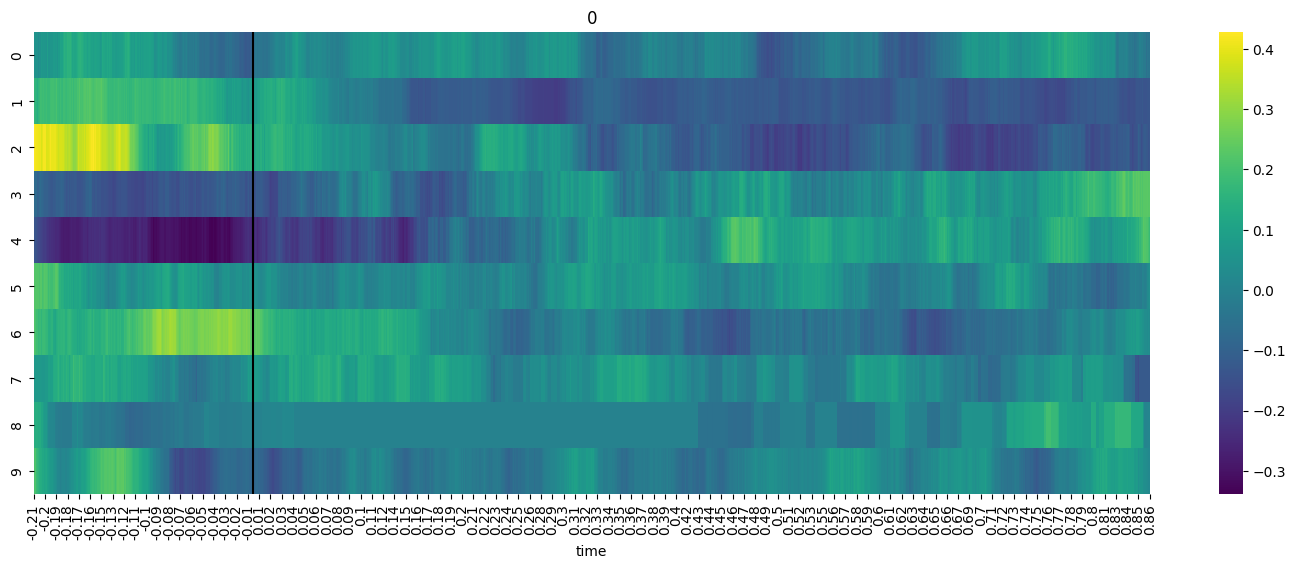

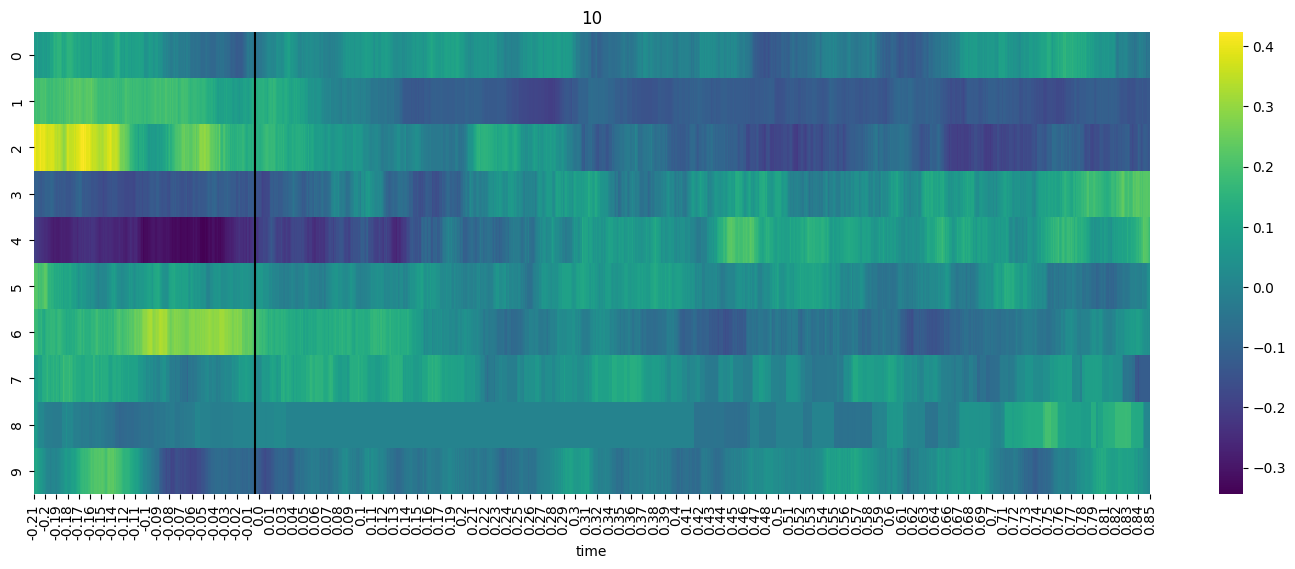

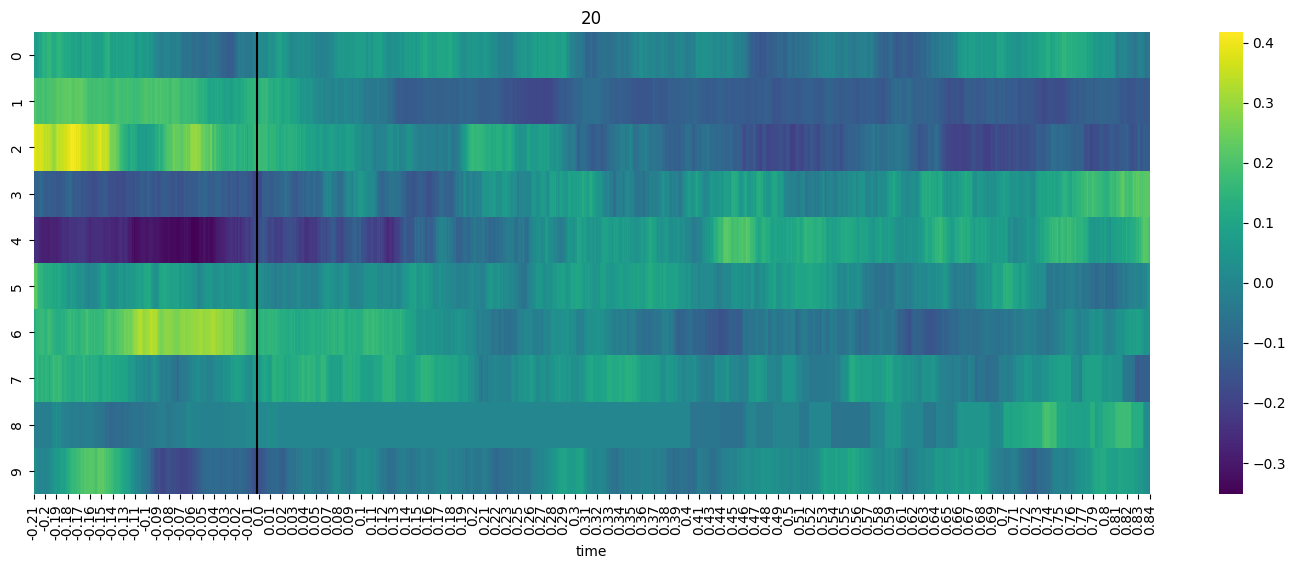

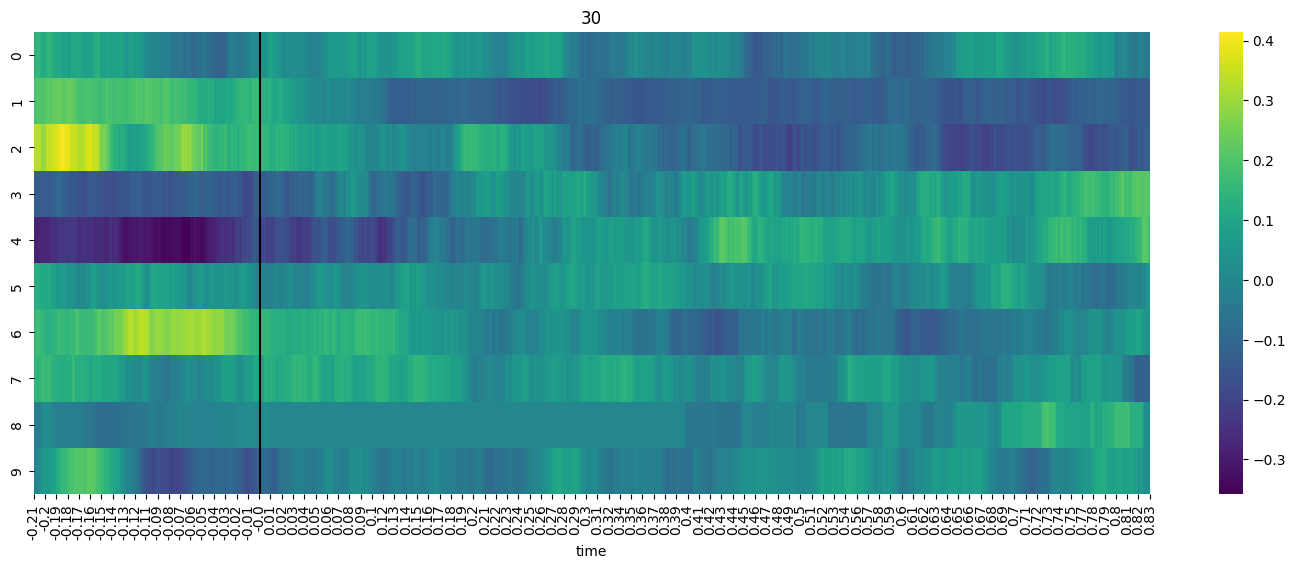

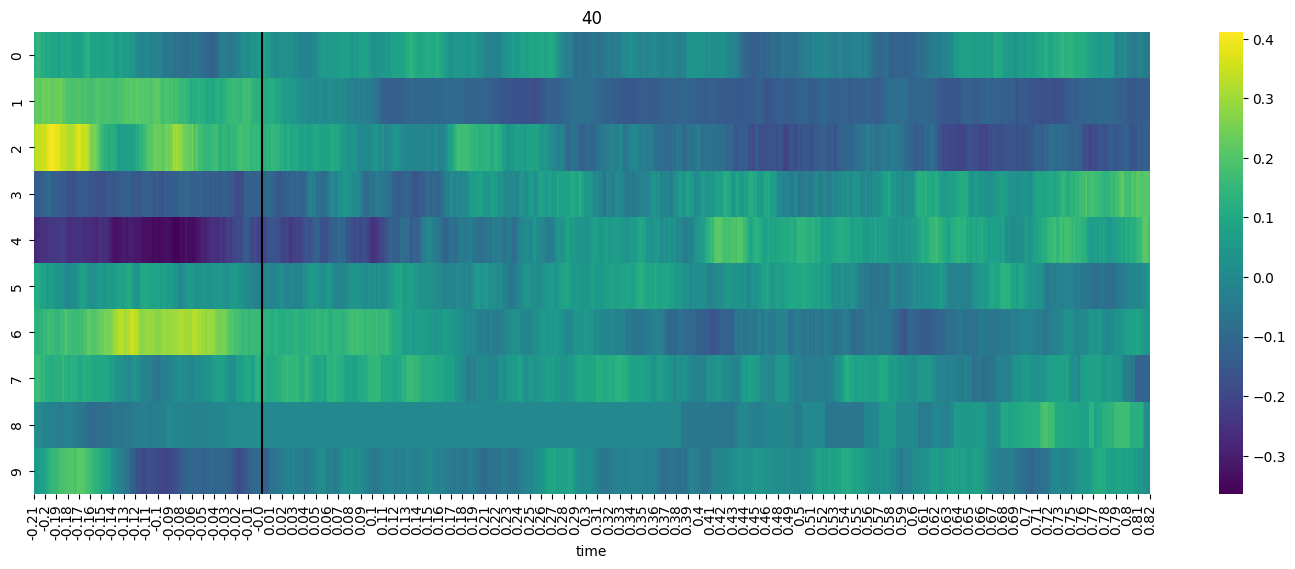

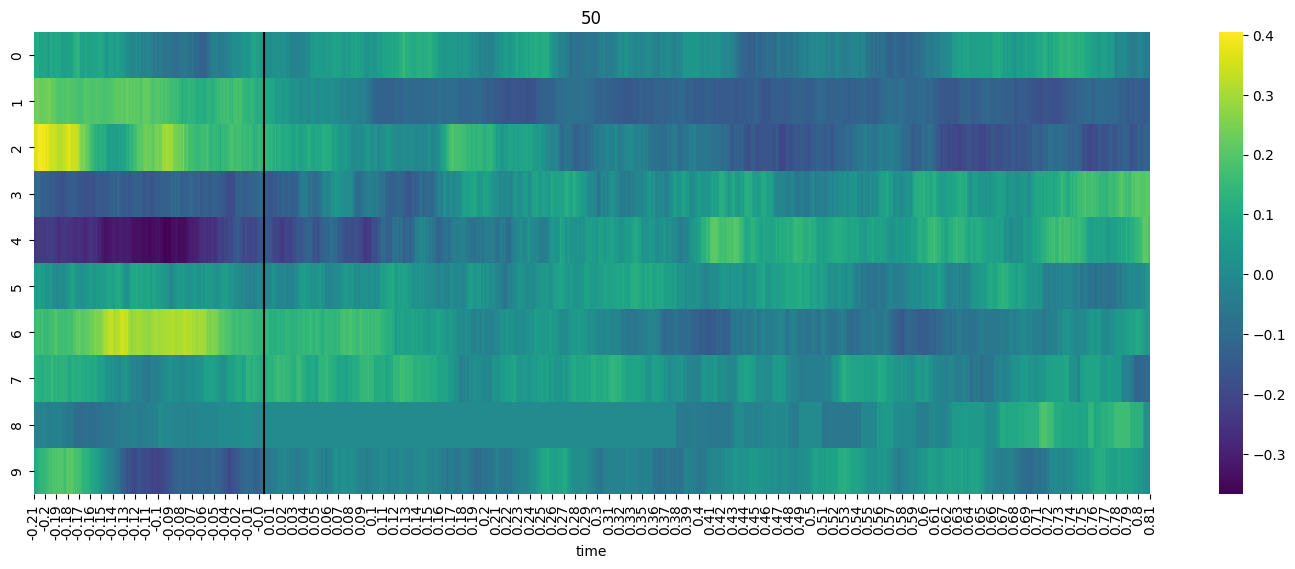

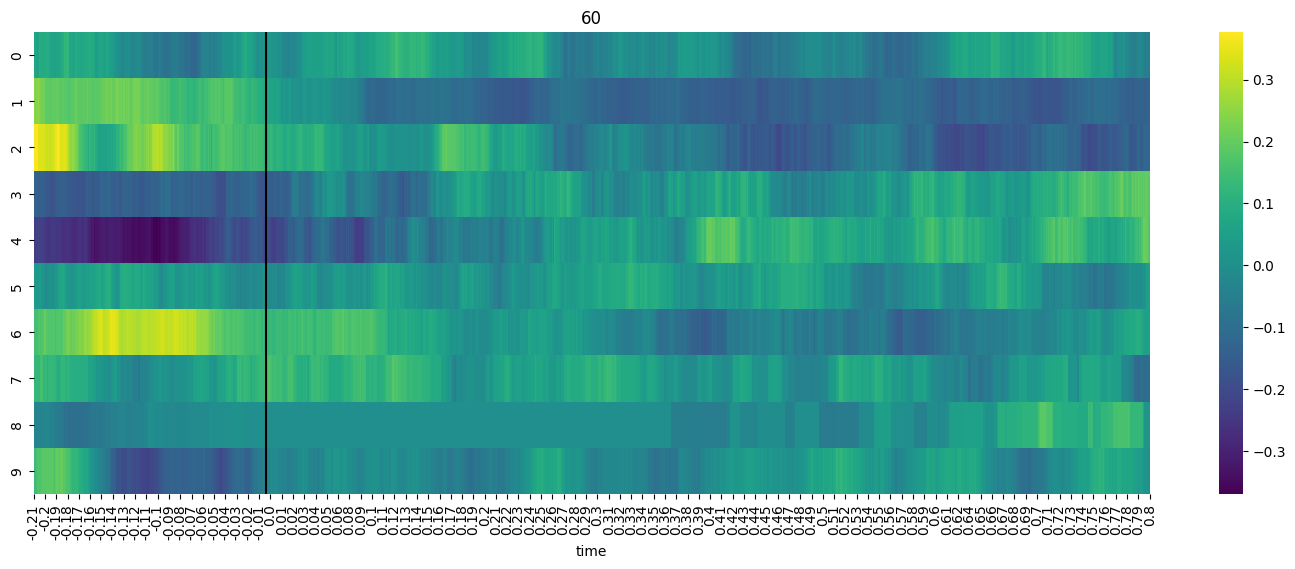

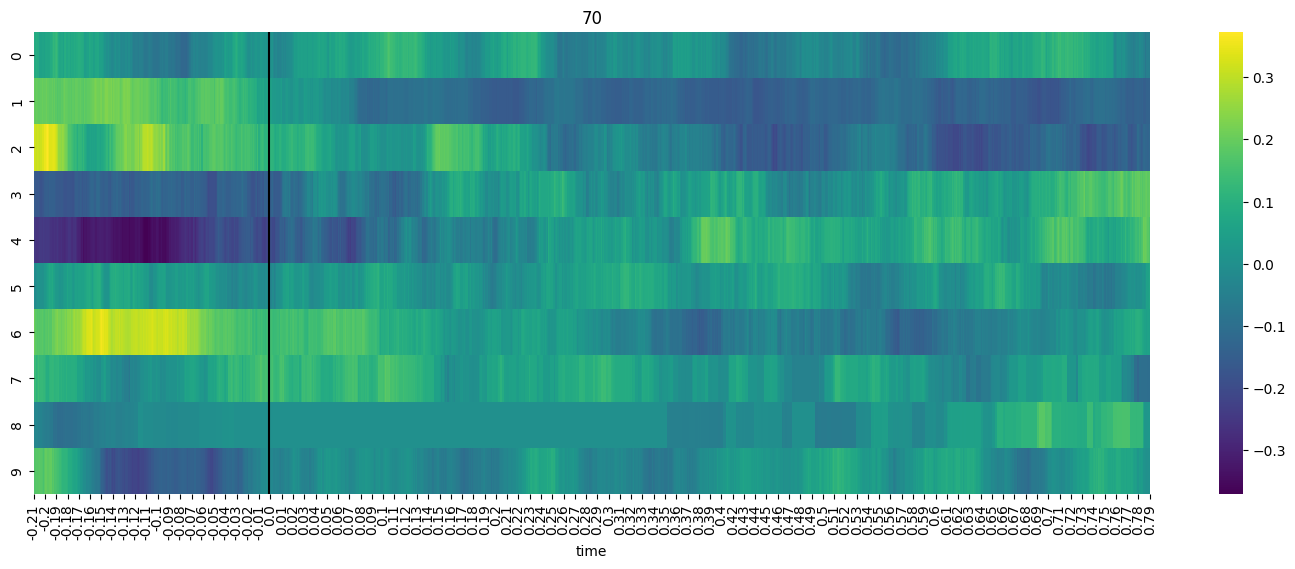

In [586]:
# LIP
win_size = 50
step = 1
t_before = 210
t_after = 400
# sample on event for the lip 
# select one neuron
for fr_shift in np.arange(0,80,10):
    neurons_coeff = []
    for n_neuron in lip_fr_samples['neuron'].unique():
        neuron_fr = lip_fr_samples[(lip_fr_samples['neuron']== n_neuron)]
        corr_coeff=compute_corr_coef(neuron_fr,t_before,t_after,win_size,step,fr_shift=fr_shift)
        neurons_coeff.append(corr_coeff)
    fig,ax = plt.subplots(figsize=(18,6))
    sns.heatmap(np.array(neurons_coeff),ax=ax,cmap='viridis')
    ax.set_xticks(np.linspace(0,len(corr_coeff),100))
    ax.set_xticklabels(np.around((np.linspace(0,len(corr_coeff),100)-t_before)/1000,2))
    ax.set_xlabel('time')
    ax.vlines(t_before,ax.get_ylim()[1],ax.get_ylim()[0],'k')
    ax.set_title(fr_shift)
    plt.show()

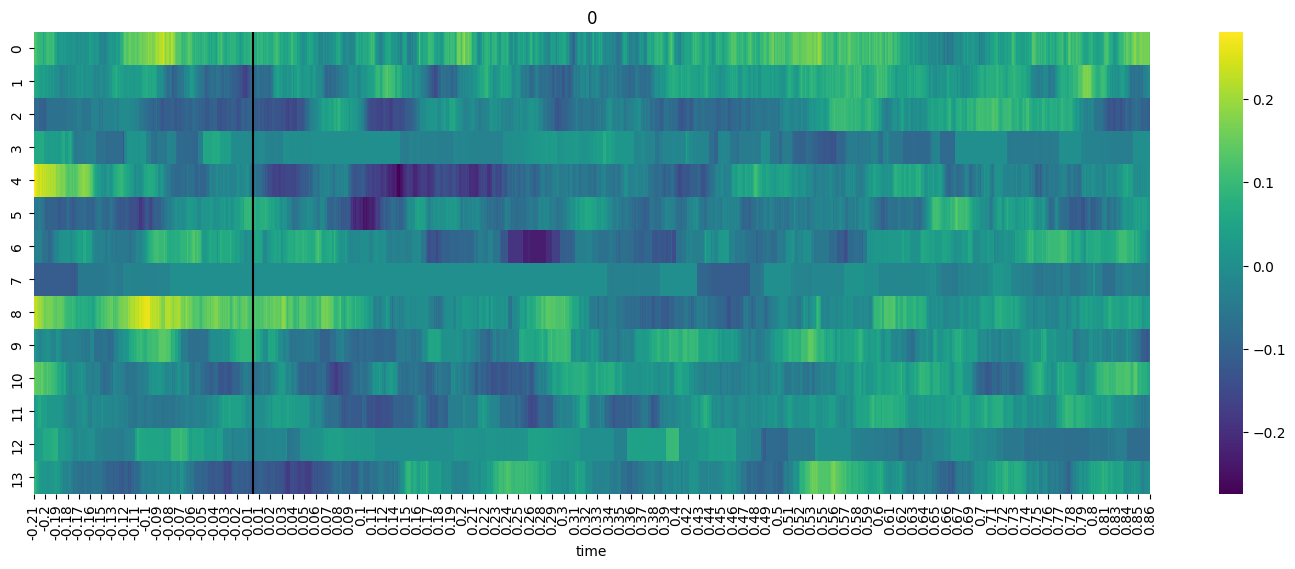

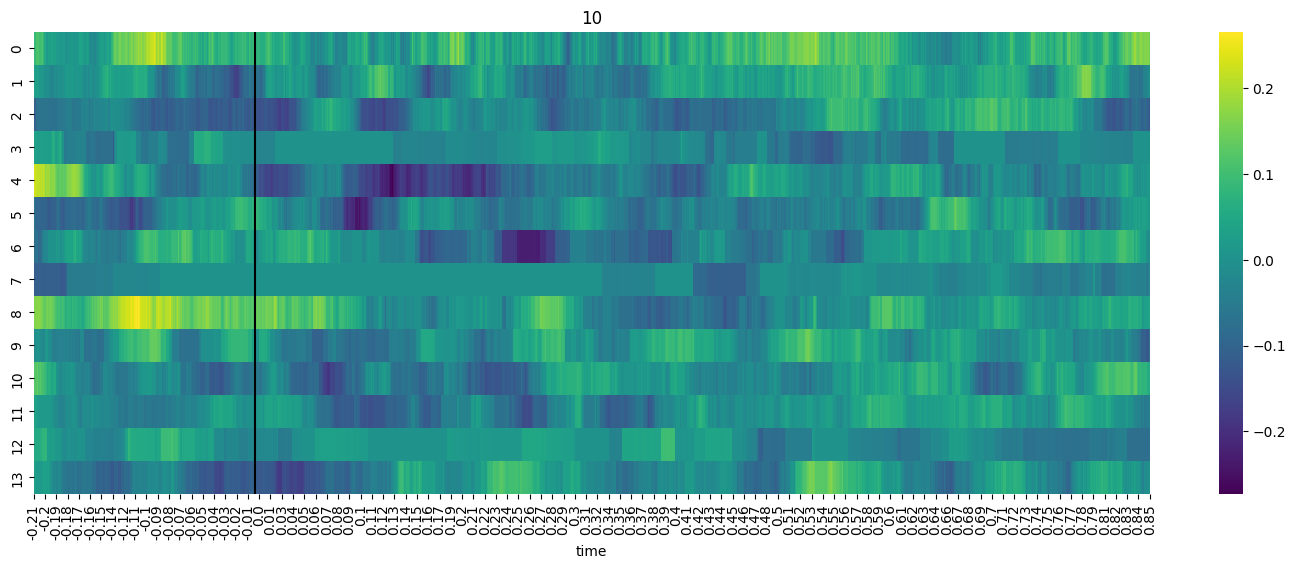

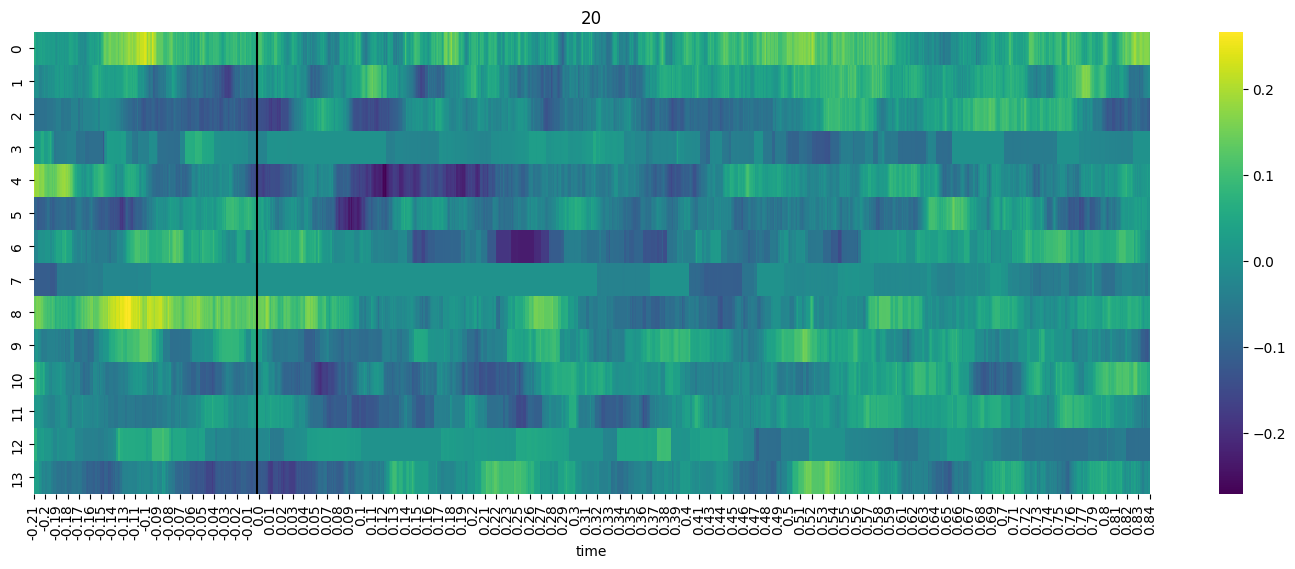

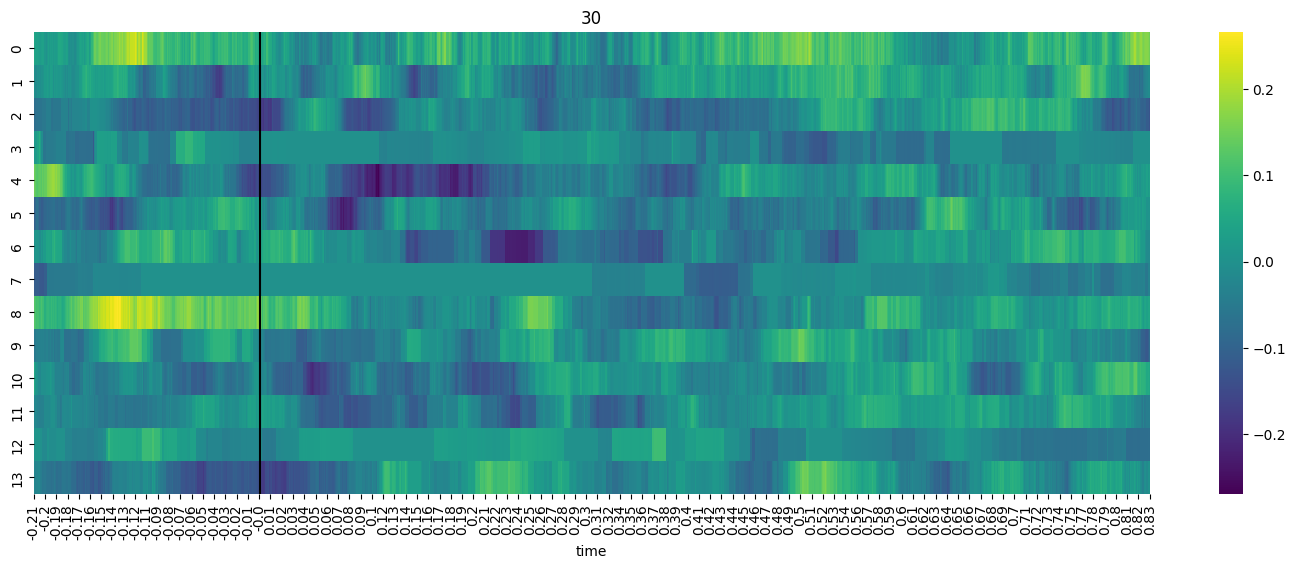

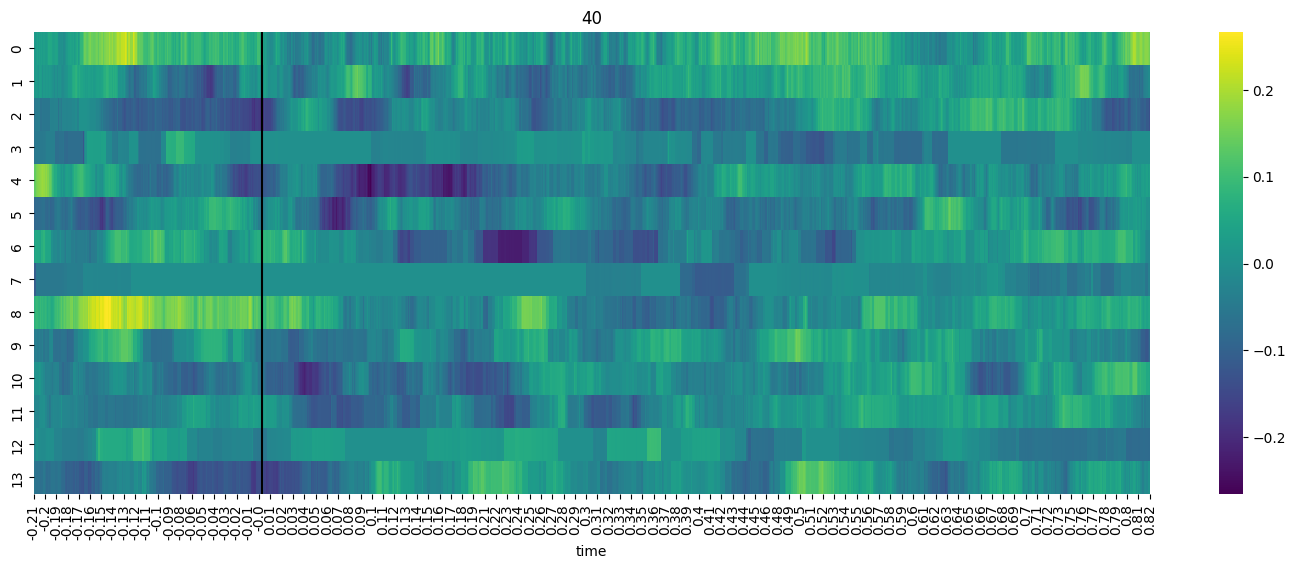

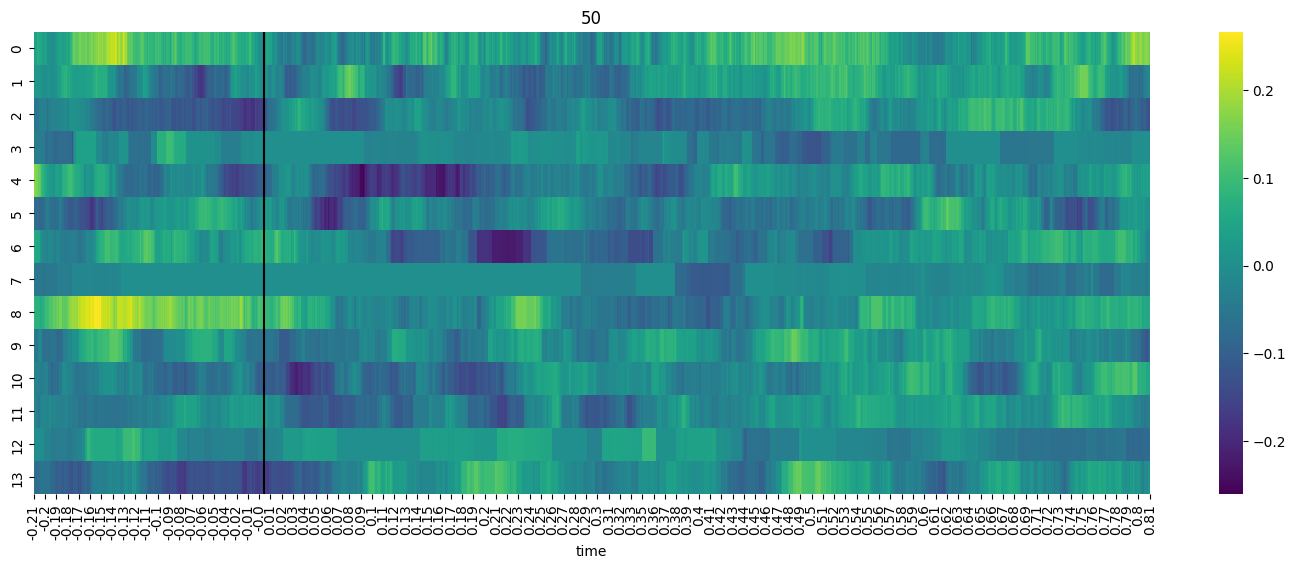

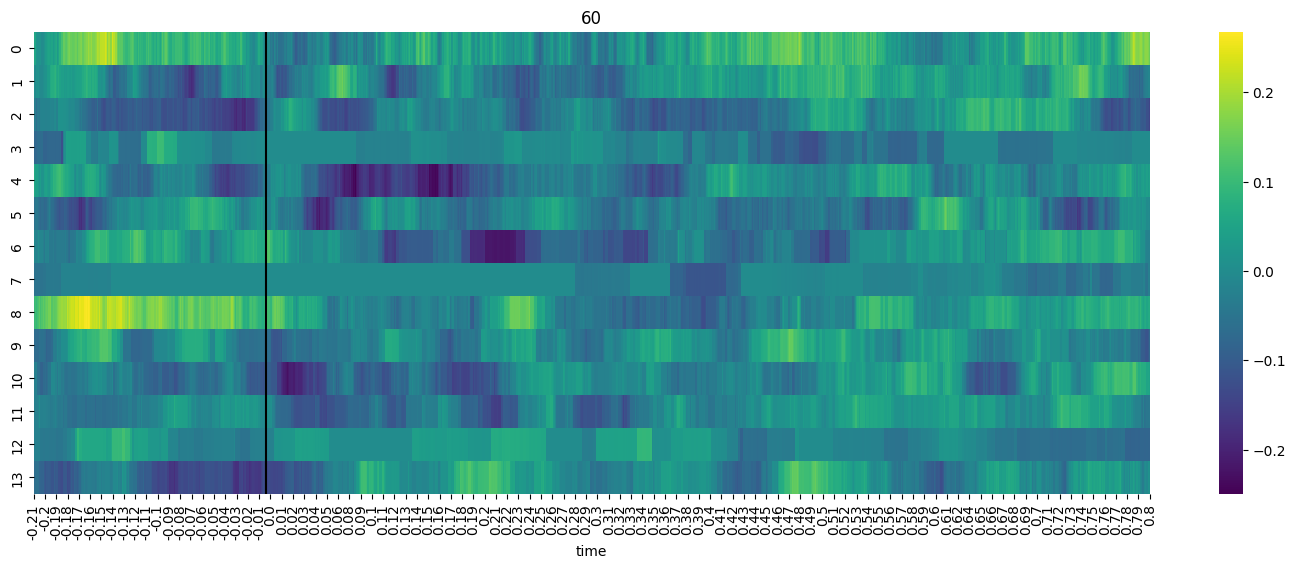

In [587]:
# V4
win_size = 50
step = 1
eyes_dilation = []
fr = []
t_before = 210
t_after = 400
# sample on event for the lip 
# select one neuron
for fr_shift in np.arange(0,70,10):
    neurons_coeff = []
    for n_neuron in v4_fr_samples['neuron'].unique():
        neuron_fr = v4_fr_samples[(v4_fr_samples['neuron']== n_neuron)]
        corr_coeff=compute_corr_coef(neuron_fr,t_before,t_after,win_size,step,fr_shift=fr_shift)
        neurons_coeff.append(corr_coeff)
    fig,ax = plt.subplots(figsize=(18,6))
    sns.heatmap(np.array(neurons_coeff),ax=ax,cmap='viridis')
    ax.set_xticks(np.linspace(0,len(corr_coeff),100))
    ax.set_xticklabels(np.around((np.linspace(0,len(corr_coeff),100)-t_before)/1000,2))
    ax.set_xlabel('time')
    ax.vlines(t_before,ax.get_ylim()[1],ax.get_ylim()[0],'k')
    ax.set_title(fr_shift)
    plt.show()

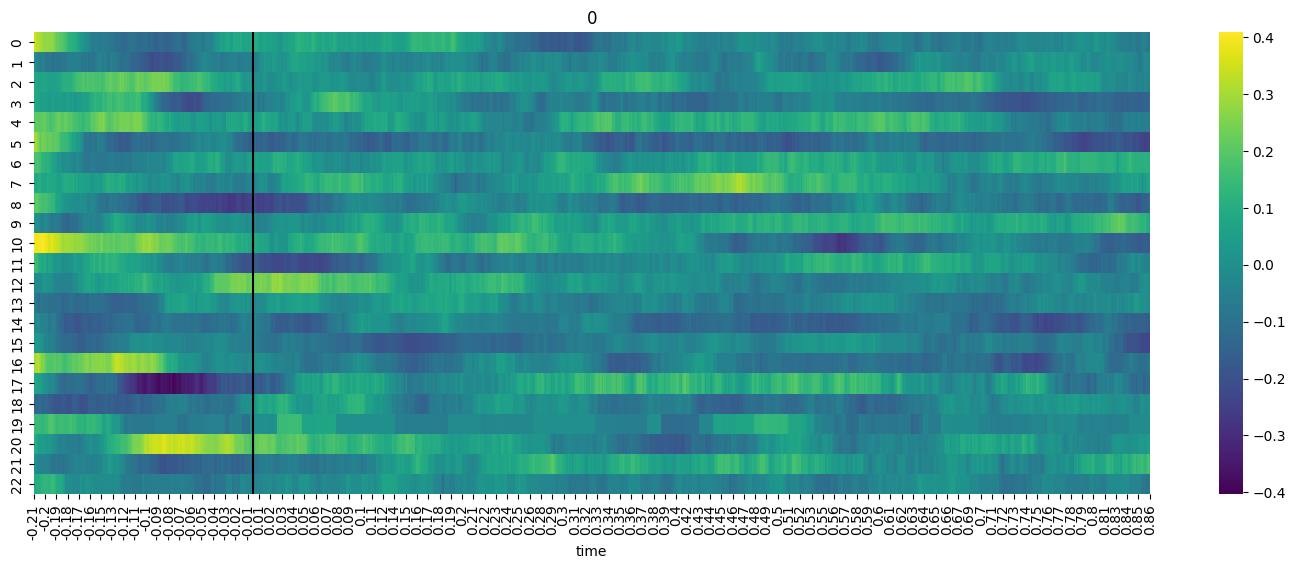

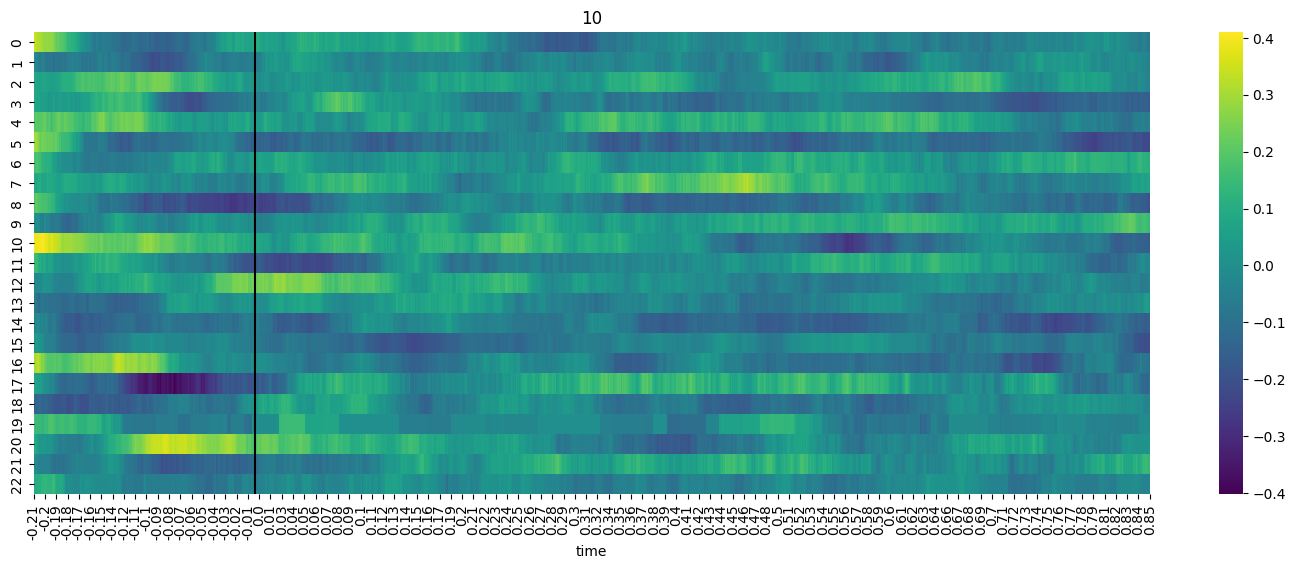

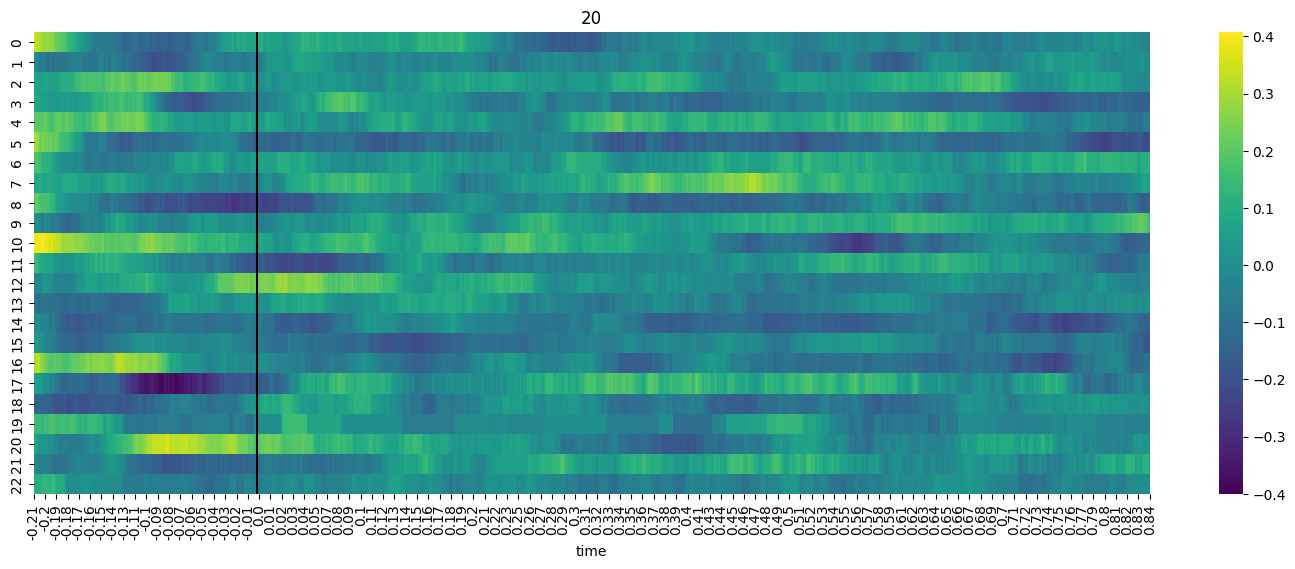

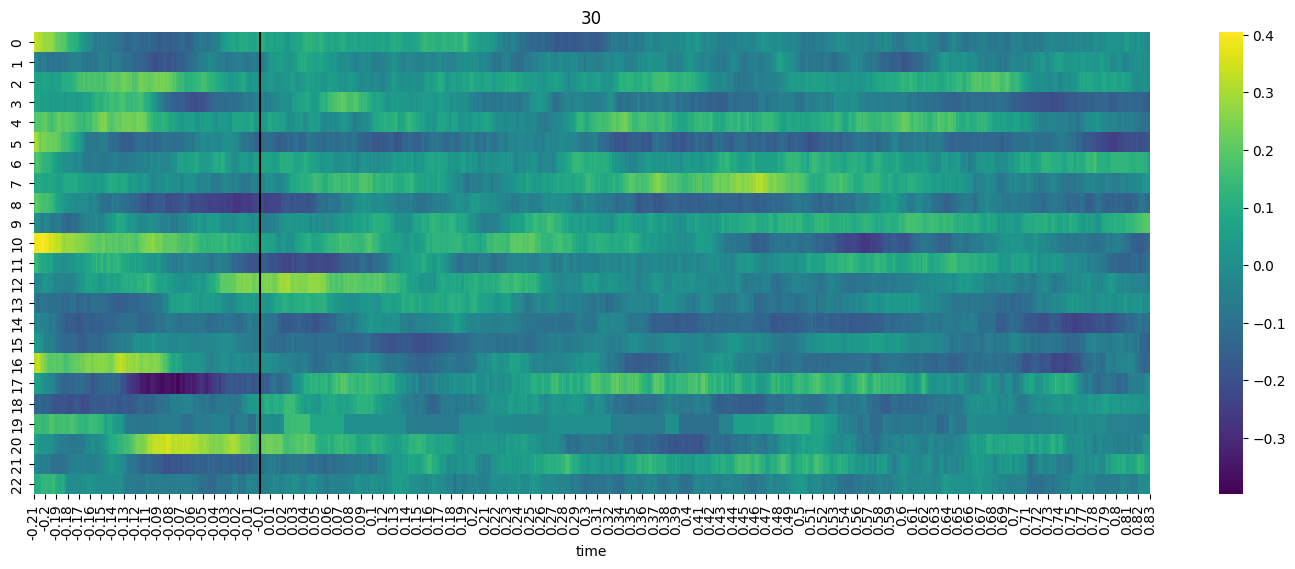

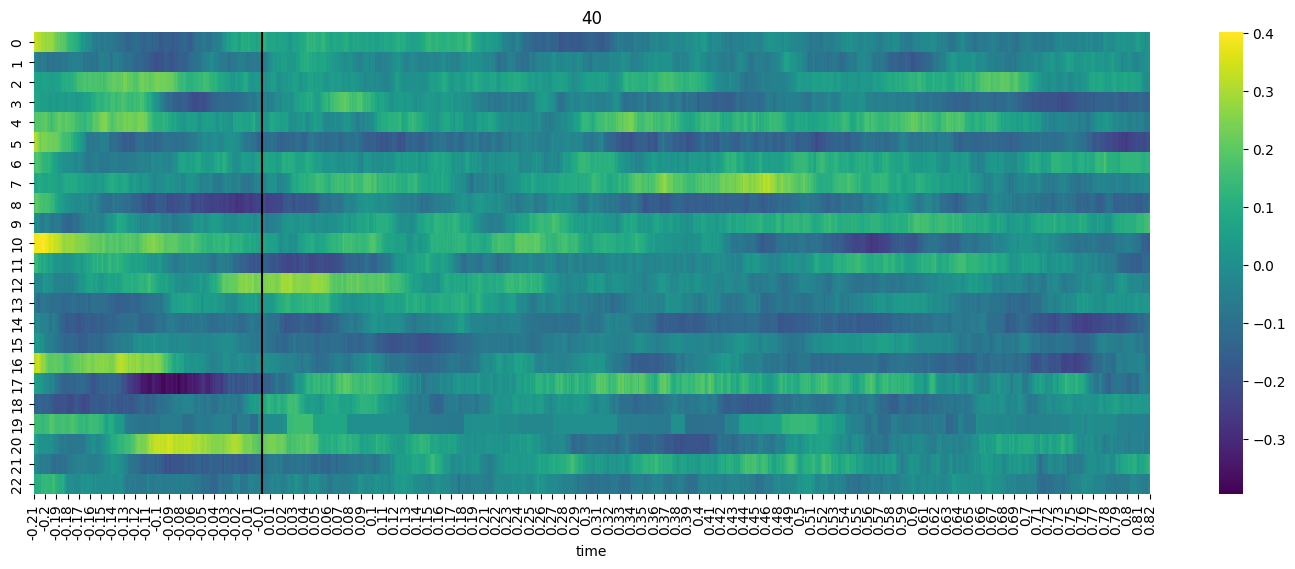

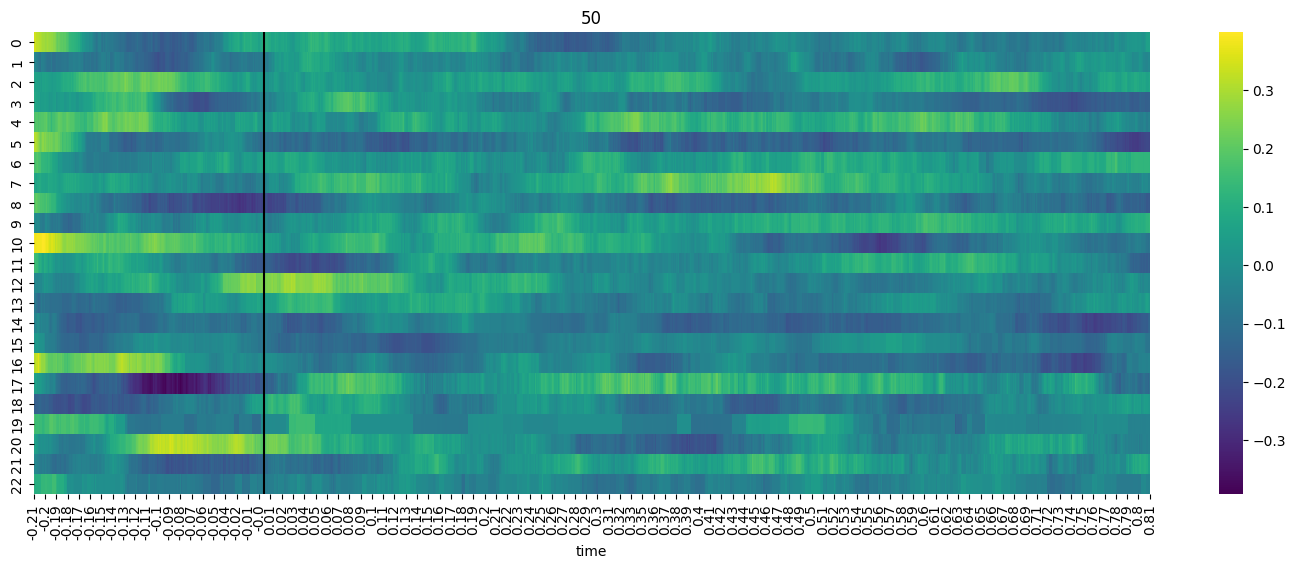

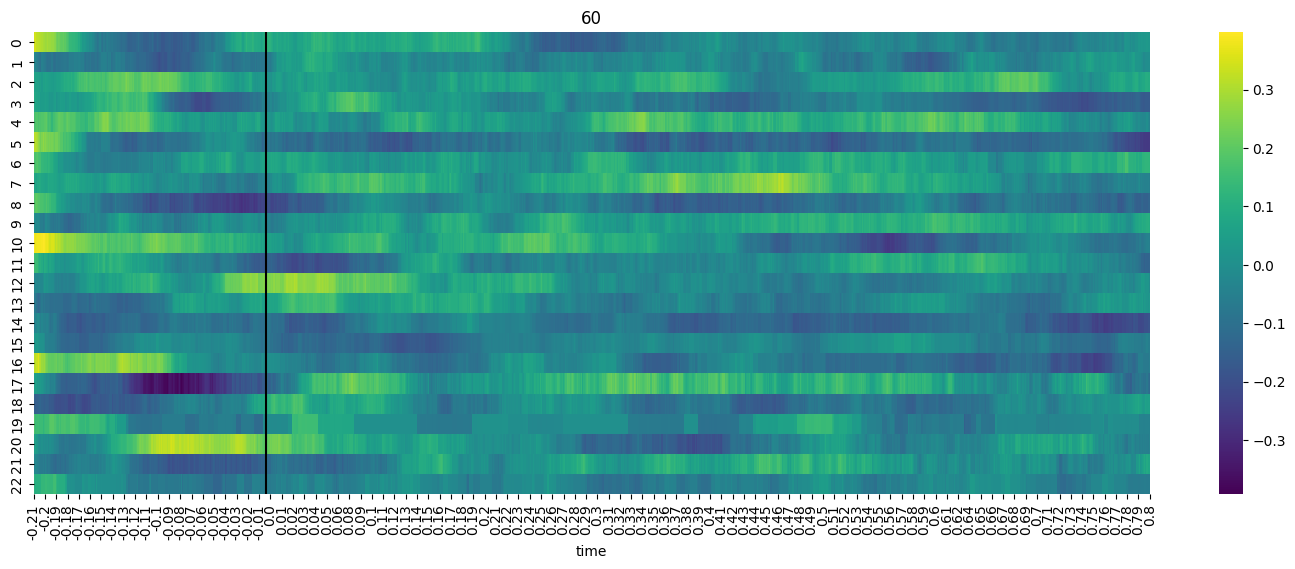

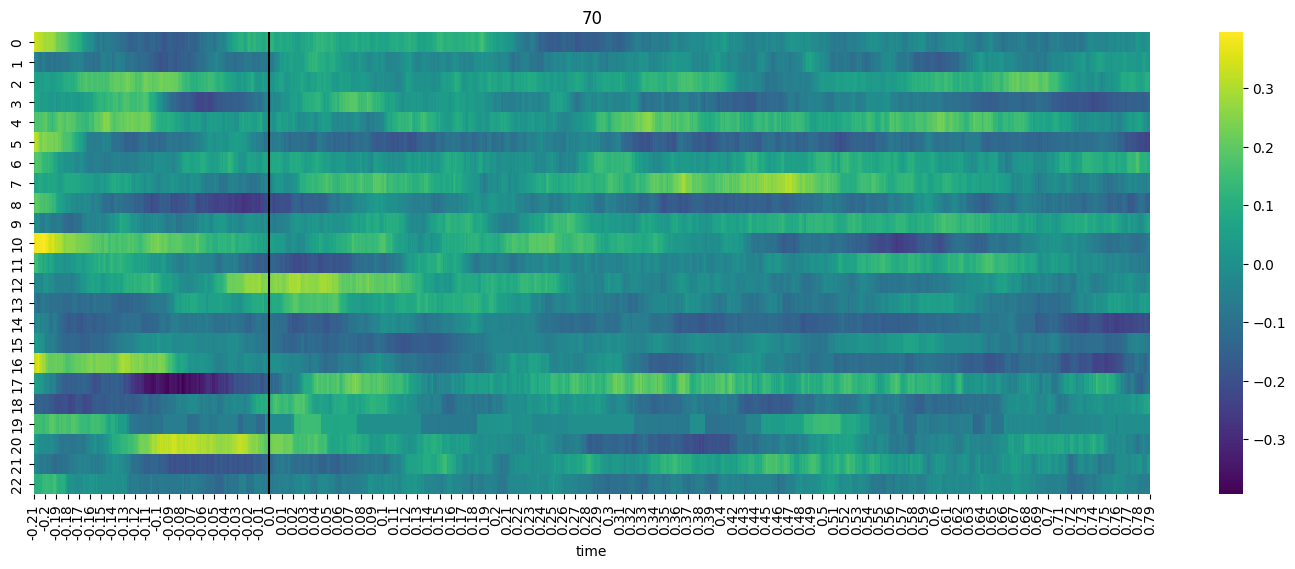

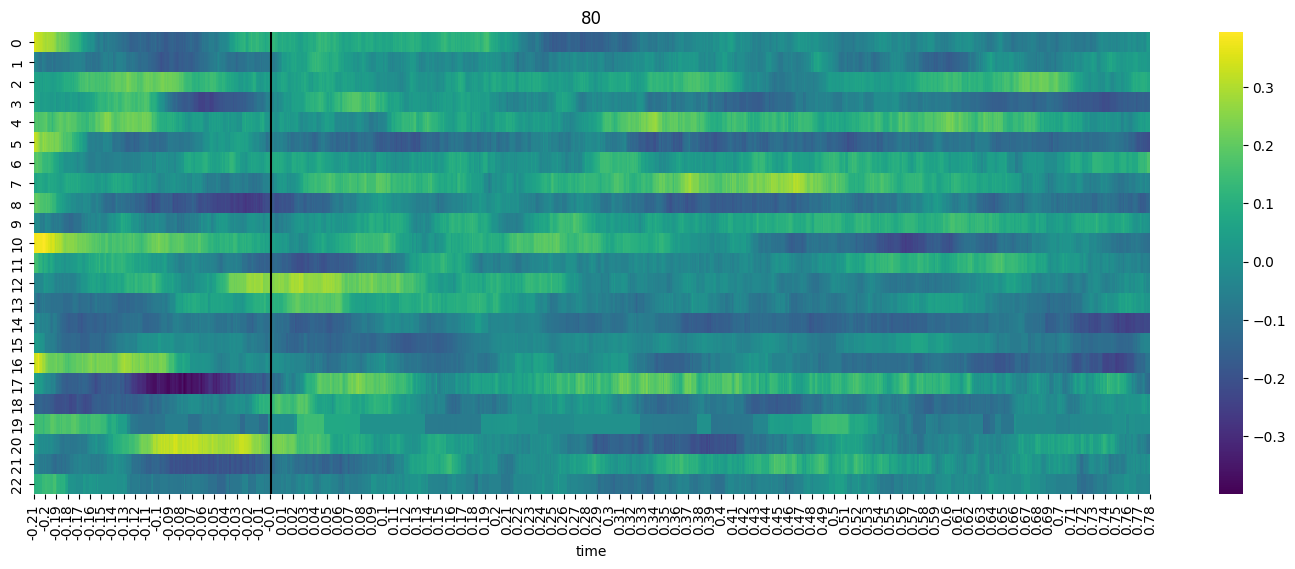

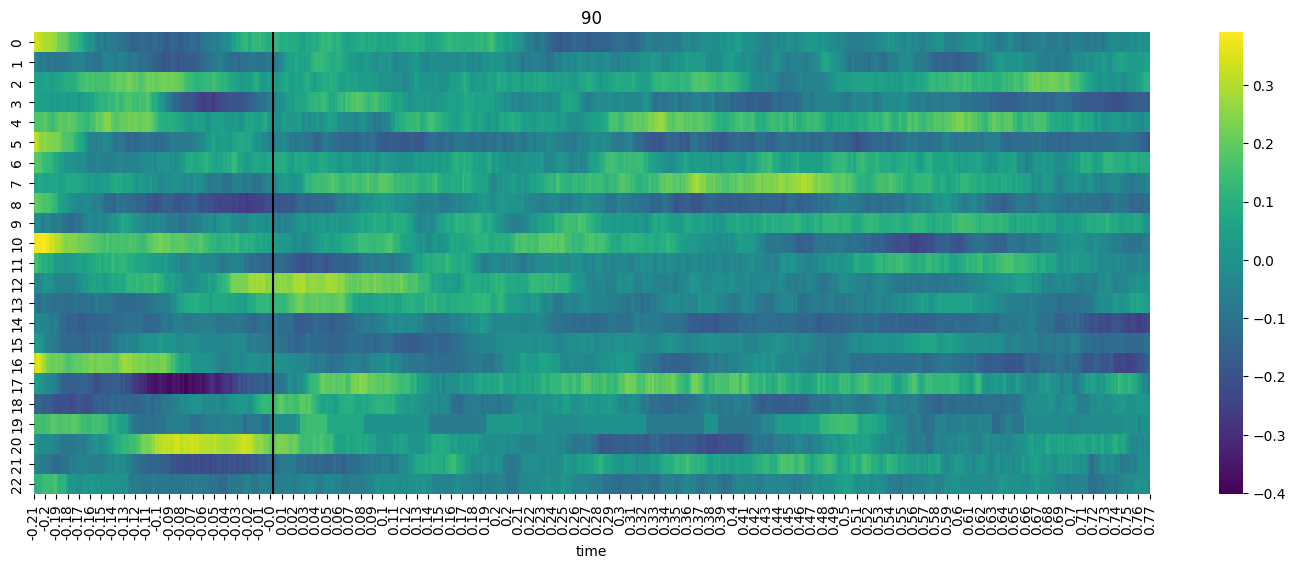

In [344]:
# PFC
win_size = 50
step = 1
eyes_dilation = []
fr = []
t_before = 210
t_after = 400
# sample on event for the lip 
# select one neuron
for fr_shift in np.arange(0,100,10):
    neurons_coeff = []
    for n_neuron in pfc_fr_samples['neuron'].unique():
        neuron_fr = pfc_fr_samples[(pfc_fr_samples['neuron']== n_neuron)]
        corr_coeff=compute_corr_coef(neuron_fr,t_before,t_after,win_size,step,eyes_shift=fr_shift)
        neurons_coeff.append(corr_coeff)
    fig,ax = plt.subplots(figsize=(18,6))
    sns.heatmap(np.array(neurons_coeff),ax=ax,cmap='viridis')
    ax.set_xticks(np.linspace(0,len(corr_coeff),100))
    ax.set_xticklabels(np.around((np.linspace(0,len(corr_coeff),100)-t_before)/1000,2))
    ax.set_xlabel('time')
    ax.vlines(t_before,ax.get_ylim()[1],ax.get_ylim()[0],'k')
    ax.set_title(fr_shift)
    plt.show()